In [24]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm
import healpy as hp
from tqdm import tqdm
import torch
import torch.nn as nn

from scipy.stats import chi2
from scipy.stats import norm

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *
from theory.limit import get_lim

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_1385/89446128.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [25]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

In [3]:
plt.rcParams.update({"text.usetex": False})


## Basline analysis

In [3]:
import sbi.utils as utils
import mlflow

In [5]:
run_id = 'c3807cac569f467f8d8ac319091e0725'
    
data_dir = '/scratch/sm8383/neural-global-astrometry/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator_anisotropic = mlflow.pytorch.load_model(data_dir + '/logs/mlruns/3/' + run_id + '/artifacts/density_estimator')

sigma_noise_model = list(density_estimator_anisotropic.children())[0].add_noise.sigma

In [7]:
run_id = 'f00c10126eac4c31a6ccc9ec4836df27'
    
data_dir = '/scratch/sm8383/neural-global-astrometry/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model(data_dir + '/logs/mlruns/2/' + run_id + '/artifacts/density_estimator')

In [7]:
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea

In [8]:
mask_roi = (sigma_noise_model[0,0].cpu() == 0).numpy()
mask_roi = torch.Tensor((mask_roi)).bool()

/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/sm8383/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colorm

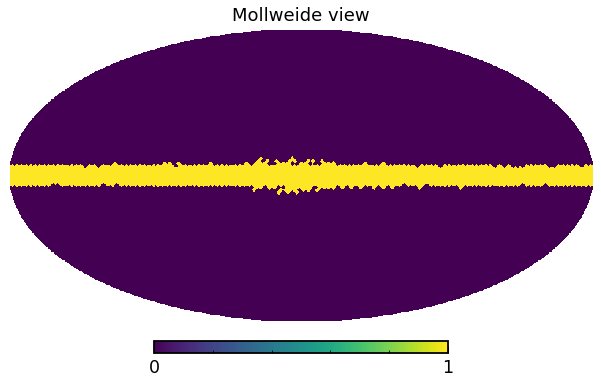

In [9]:
hp.mollview(mask_roi, nest=True)

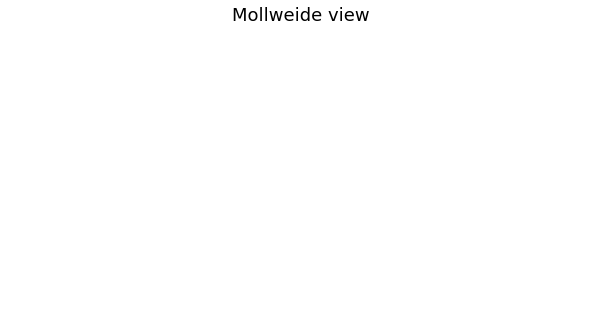

In [10]:
hp.mollview(list(density_estimator.children())[0].embedding_net_y.mask, nest=True)

In [11]:
list(density_estimator.children())[0].add_noise.sigma

0.0023

In [12]:
list(density_estimator.children())[0].add_noise.sigma = 0.
list(density_estimator_anisotropic.children())[0].add_noise.sigma = 0.

In [13]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        x = x.to(device)
#         self.sigma = self.sigma.to(device)
        sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
        x = x + sampled_noise
        return x 

In [14]:
device = 'cuda'

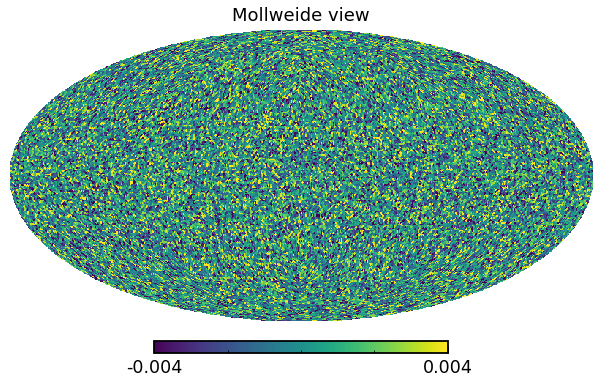

In [17]:
x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_150_{}.npy".format(i))) for i in range(20)]
x_test = torch.cat(x_test, axis=0)

gn = GaussianNoise(sigma=0.0023).to(device)
x_test = gn(x_test.to(device))

hp.mollview(x_test.cpu().numpy()[0][0], nest=True, min=-0.004, max=0.004)

In [18]:
n_trials = x_test.shape[0]  # Number of samples to simulate
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean = np.mean(out, axis=0)
out_mean -= np.max(out_mean)

100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


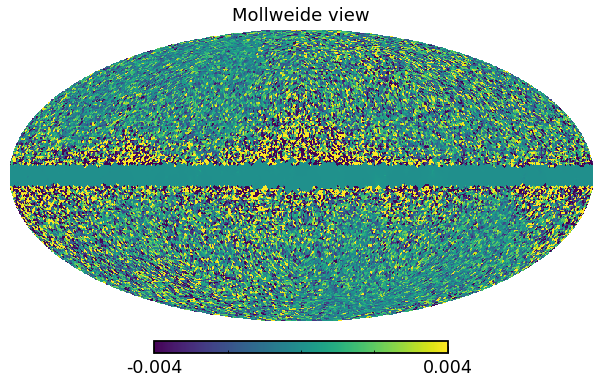

In [51]:
x_test = [torch.Tensor(np.load("../../sbi-astrometry/data/samples/x_test_150_{}.npy".format(i))) for i in range(20)]
x_test = torch.cat(x_test, axis=0)

gn = GaussianNoise(sigma=sigma_noise_model.to(device)).to(device)
x_test = gn(x_test.to(device))

# hp.mollview(x_test.cpu().numpy()[0][0], nest=True, min=-0.004, max=0.004)

n_trials = x_test.shape[0]  # Number of samples to simulate
n_test = 100  # Number of points in f_sub over which to compute likelihood ratio

out = np.zeros((n_trials, n_test))

theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean_anistropic = np.mean(out, axis=0)
out_mean_anistropic -= np.max(out_mean_anistropic)

for i in tqdm(range(n_test)):
    out[:, i] = density_estimator_anisotropic.to(device)(x_test.to(device), theta_test[i].repeat(n_trials).unsqueeze(1).to(device)).to('cpu').detach().numpy()[:, 0] 
    
out_mean_anistropic_anisotropic = np.mean(out, axis=0)
out_mean_anistropic_anisotropic -= np.max(out_mean_anistropic_anisotropic)

In [6]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

In [7]:
# np.save("../data/plot_arrays/sigma_noise_model.npy", sigma_noise_model.cpu().numpy())
# np.save("../data/plot_arrays/theta_test.npy", theta_test)
# np.save("../data/plot_arrays/out_mean.npy", out_mean)
# np.save("../data/plot_arrays/out_mean_anistropic.npy", out_mean_anistropic)
# np.save("../data/plot_arrays/out_mean_anistropic_anisotropic.npy", out_mean_anistropic_anisotropic)

In [8]:
sigma_noise_model = np.load("../data/plot_arrays/sigma_noise_model.npy")
theta_test = np.load("../data/plot_arrays/theta_test.npy")
out_mean = np.load("../data/plot_arrays/out_mean.npy")
out_mean_anistropic = np.load("../data/plot_arrays/out_mean_anistropic.npy")
out_mean_anistropic_anisotropic = np.load("../data/plot_arrays/out_mean_anistropic_anisotropic.npy")

In [44]:
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})


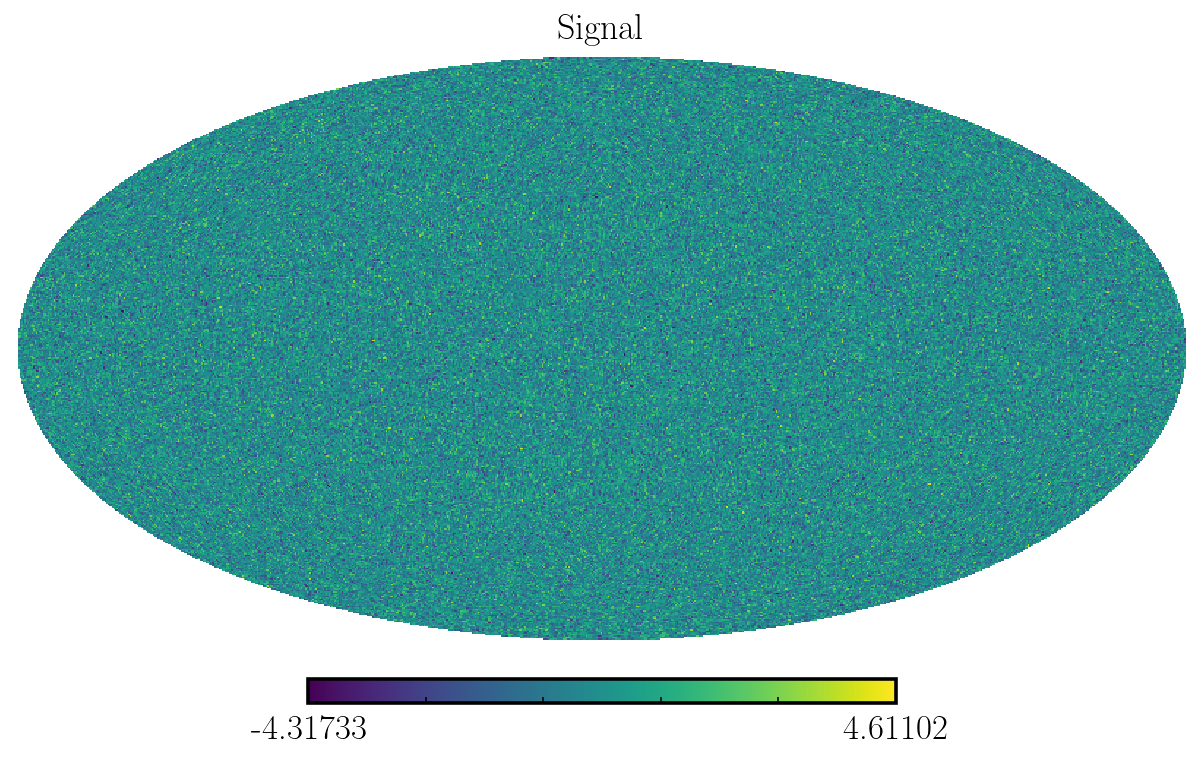

In [35]:
nside = 128
npix = hp.nside2npix(nside)
np.random.seed(12)
signal = np.random.normal(size=npix)
hp.mollview(signal, title="Signal")

gal_cut = np.radians(10)
mask = np.zeros(npix, dtype=np.float32)
mask[hp.query_strip(nside, np.pi/2-gal_cut, np.pi/2+gal_cut)] = 1
mask[hp.query_disc(nside, hp.ang2vec(np.pi/2, 0), np.radians(20))] = 1



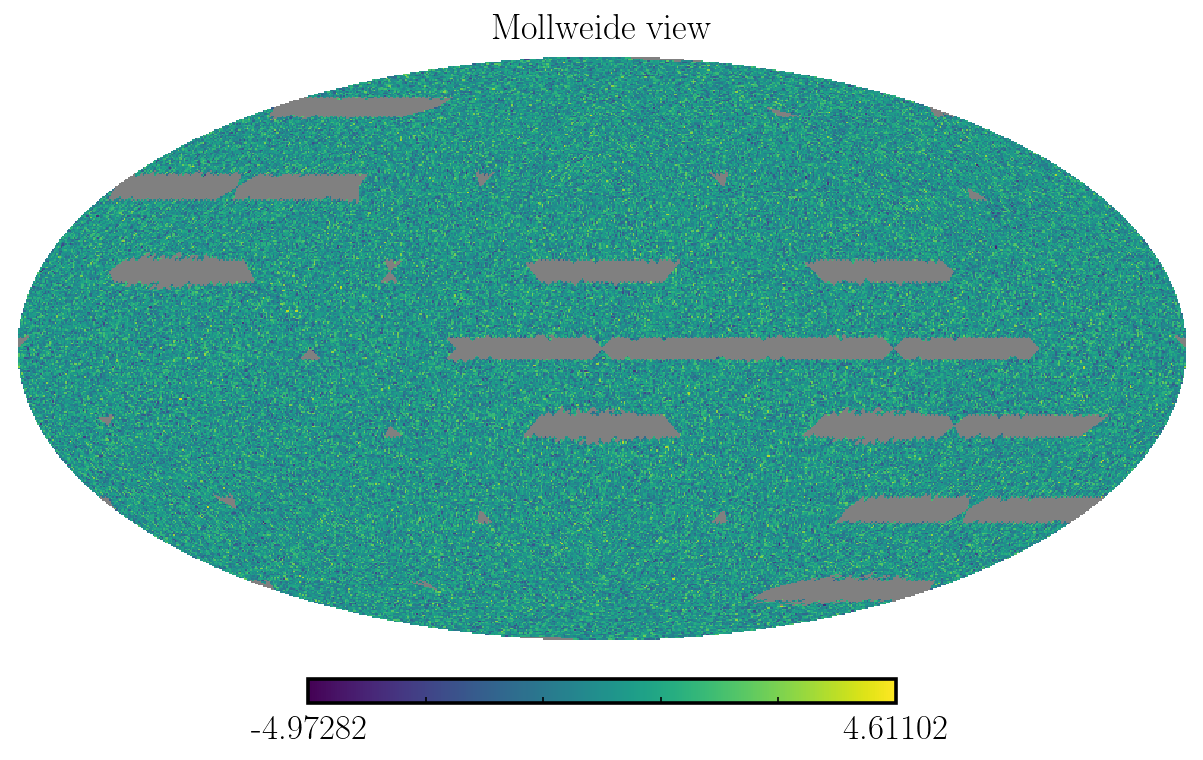

In [57]:
mask_alpha = (sigma_noise_model[0][0] == 0)
sig = hp.ma(signal)
sig.mask = mask_alpha + 0.
hp.mollview(sig, nest=True)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
/var/folders/d8/fkpry78n5tz_ztp9lvhv88fm0000gn/T/ipykernel_1385/3819782792.py:67: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(wspace=0.25)


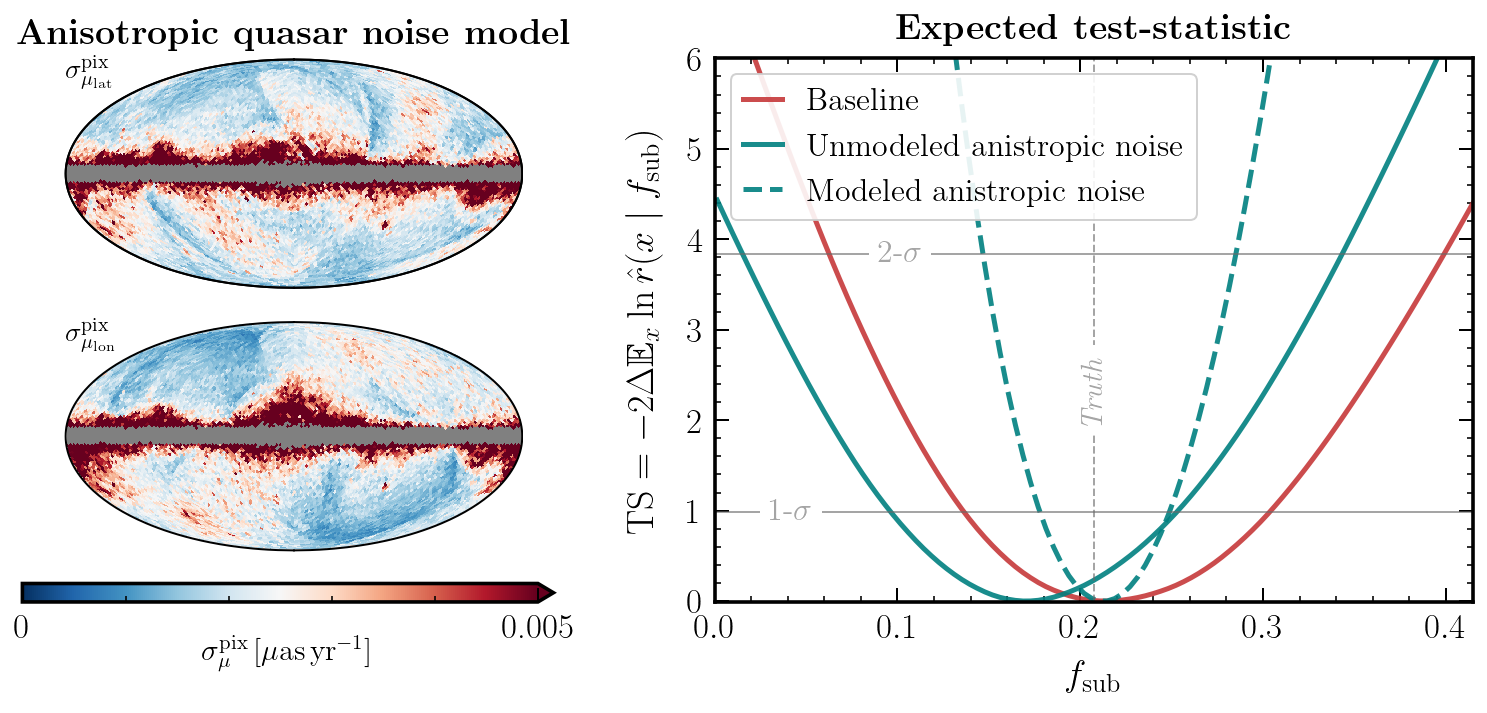

In [123]:
cbar_max = 0.005
cmap = cm.RdBu_r

fig = plt.figure(constrained_layout=True, figsize=(13, 5))
gs = fig.add_gridspec(3, 2, height_ratios=(1,1,0.08), width_ratios=(0.7,1))

ax1 = fig.add_subplot(gs[0, 0])
the_map = hp.ma(sigma_noise_model[0][1])
the_map.mask = (sigma_noise_model[0][1] == 0) + 0.
hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=r"\bf{Anisotropic quasar noise model}")
hp.graticule(dmer=360,dpar=360,alpha=0)

f = plt.gcf()
hax1 = f.get_axes()[0]
hax1.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lat}}^\mathrm{pix}$", fontsize=14)

ax2 = fig.add_subplot(gs[1, 0])
the_map = hp.ma(sigma_noise_model[0][0])
the_map.mask = (sigma_noise_model[0][0] == 0) + 0.
hp.mollview(the_map, nest=True, min=0, max=cbar_max, cmap=cmap, hold=True, cbar=None, title=None, unit=r"$\sigma_{\mu_\mathrm{lon}}$")
hp.graticule(dmer=360,dpar=360,alpha=0)

f = plt.gcf()
hax2 = f.get_axes()[1]
hax2.text(-2, 0.75, "$\sigma_{\mu_\mathrm{lon}}^\mathrm{pix}$", fontsize=14)

fig_cb = plt.gcf()
ax_cb = plt.gca()
image = ax_cb.get_images()[0]

ax4 = fig.add_subplot(gs[2, 0])
cbar = plt.colorbar(image, cax=ax4, orientation='horizontal', ticks=[0, cbar_max], shrink=0.6, extend='max', extendfrac=0.03)
cbar.set_label(label=r"$\sigma_\mu^\mathrm{pix}$\,[$\mu$as\,yr$^{-1}$]", labelpad=-4, fontsize=15)
cbar.ax.set_xticklabels(['0', '0.005']) 

ax3 = fig.add_subplot(gs[:, 1])

theta_multiplier = (f_sub_fid / 150)

ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean, color=cols_default[0], label="Baseline")
ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic, color='teal', label="Unmodeled anistropic noise")
ax3.plot(theta_multiplier * theta_test[:, 0], -2 * out_mean_anistropic_anisotropic, color='teal', ls='--', label="Modeled anistropic noise")

ax3.axhline(chi2.isf(1 - .95, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax3.text(f_sub_fid / 3 + 0.02, chi2.isf(1 - .95, 1), r"2-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.axhline(chi2.isf(1 - .68, 1), color='dimgrey', alpha=0.6, lw=1)
t = ax3.text(0.03, chi2.isf(1 - .68, 1), r"1-$\sigma$",  color='dimgrey', alpha=0.6, fontsize=16, verticalalignment='center')
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.axvline(f_sub_fid, color='dimgrey', lw=1, ls='--', alpha=0.6)
t = ax3.text(f_sub_fid, 2, r"\emph{Truth}", rotation=90, horizontalalignment='center', fontsize=15, color='dimgrey', alpha=0.6)
t.set_bbox(dict(facecolor='white', alpha=1., edgecolor='white'))

ax3.set_ylim(-0.01, 6)
ax3.set_xlim(0.0, 0.415)

ax3.set_xlabel(r"$f_\mathrm{sub}$")
ax3.set_ylabel(r"$\mathrm{TS}  = -2 \Delta \mathbb{E}_x\ln \hat r(x\mid f_\mathrm{sub}) $")

ax3.set_title(r"\bf{Expected test-statistic}", y=1.008)

ax3.legend(loc='upper left', frameon=True, framealpha=0.9, handlelength=1.2, fontsize=16)

# plt.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.savefig("../paper/journal-response-v1/anistropic_noise.pdf", bbox_inches='tight', pad_inches=0.1)